In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, confusion_matrix
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [34]:
# 📥 Load dataset
df = pd.read_csv("Lending Club Loan.csv")

In [35]:
# 🔍 Initial Inspection
print("🔼 Head:\n", df.head())
print("\n🔽 Tail:\n", df.tail())
print("\n📐 Shape:", df.shape)
print("\n📌 Columns:", df.columns.tolist())
print("\n❓ Missing Values:\n", df.isnull().sum()[df.isnull().sum() > 0])
print("\n📊 Data Types:\n", df.dtypes)

🔼 Head:
                  emp_title  emp_length state homeownership  annual_income  \
0  global config engineer          3.0    NJ      MORTGAGE        90000.0   
1   warehouse office clerk        10.0    HI          RENT        40000.0   
2                 assembly         3.0    WI          RENT        40000.0   
3         customer service         1.0    PA          RENT        30000.0   
4     security supervisor         10.0    CA          RENT        35000.0   

   verified_income  debt_to_income  annual_income_joint  \
0         Verified           18.01                  NaN   
1     Not Verified            5.04                  NaN   
2  Source Verified           21.15                  NaN   
3     Not Verified           10.16                  NaN   
4         Verified           57.96              57000.0   

  verification_income_joint  debt_to_income_joint  ...  sub_grade  \
0                       NaN                   NaN  ...         C3   
1                       NaN        

In [41]:
numeric_df = df.select_dtypes(include=[np.number])

# 📊 Outlier Detection (IQR Method)
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1
outliers = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).sum()
print("\n⚠️ Outliers Detected Per Column:\n", outliers[outliers > 0])


⚠️ Outliers Detected Per Column:
 annual_income                    508
debt_to_income                   221
annual_income_joint               68
delinq_2y                       1424
months_since_last_delinq           4
earliest_credit_line             313
inquiries_last_12m               349
total_credit_lines               223
open_credit_lines                327
total_credit_limit               351
total_credit_utilized            568
num_collections_last_12m         127
num_historical_failed_to_pay    1414
months_since_90d_late              7
current_accounts_delinq            1
total_collection_amount_ever    1365
current_installment_accounts     815
accounts_opened_24m              211
num_satisfactory_accounts        324
num_accounts_30d_past_due          1
num_active_debit_accounts        263
total_debit_limit                552
num_total_cc_accounts            257
num_open_cc_accounts             523
num_cc_carrying_balance          248
num_mort_accounts                304
acc

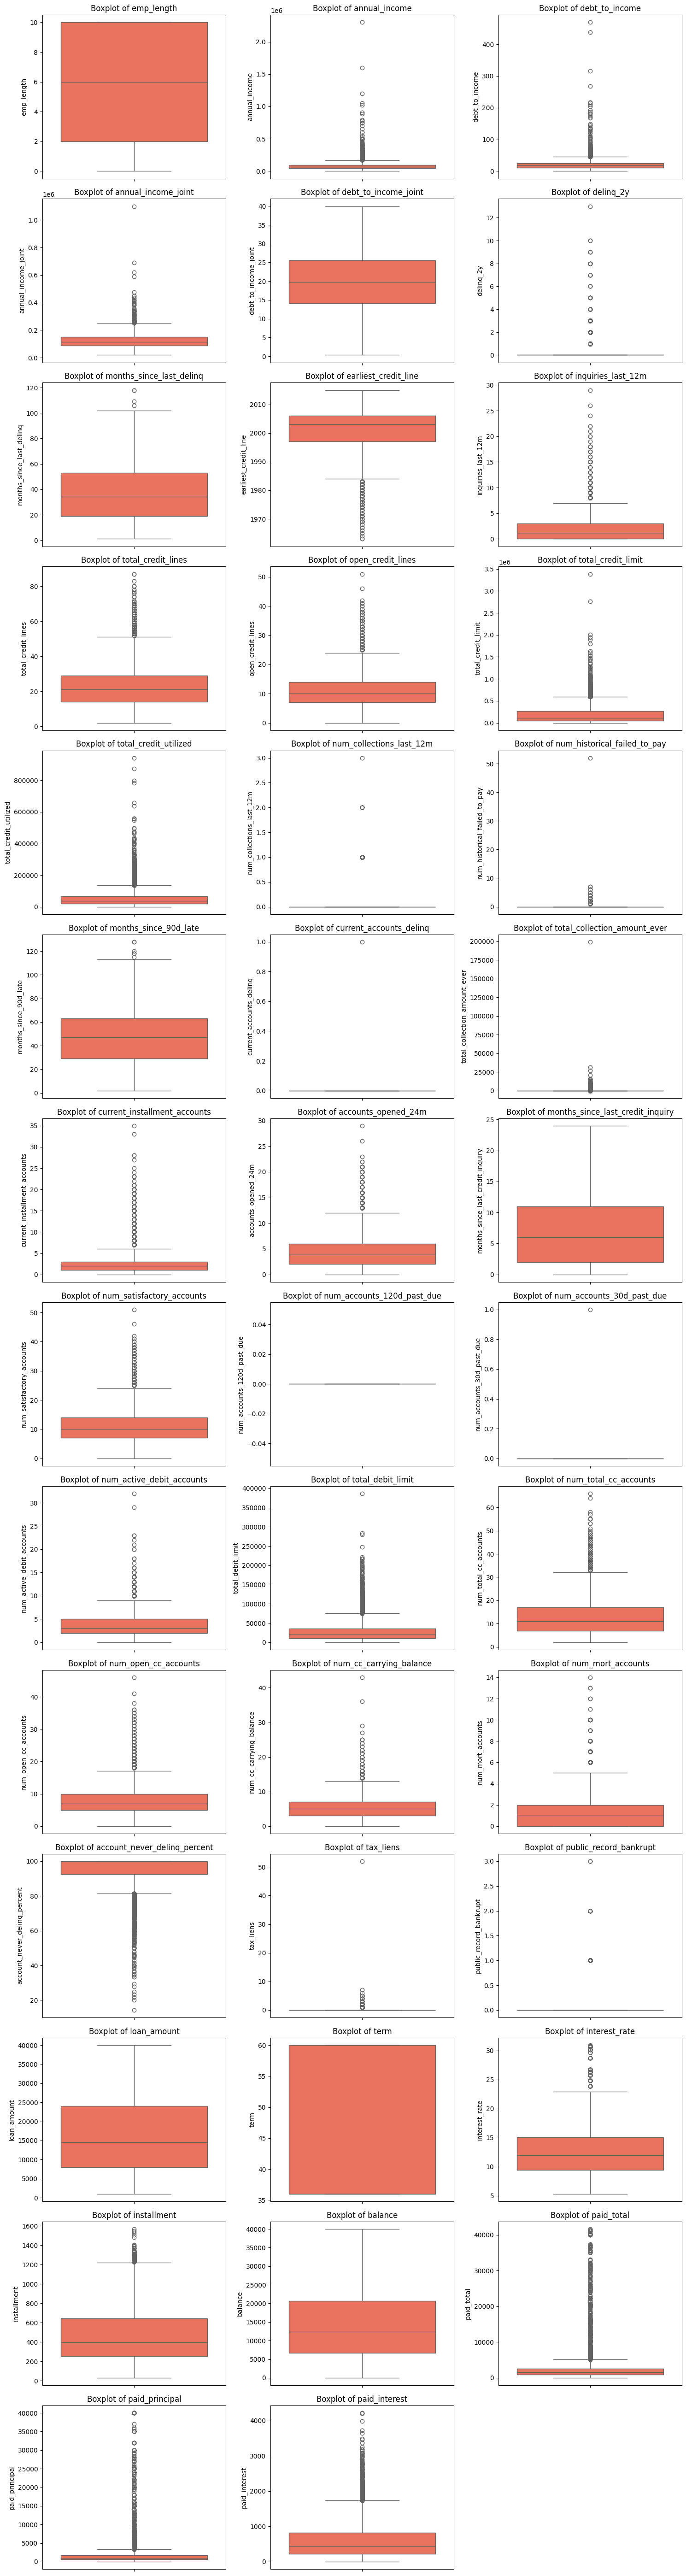

In [ ]:
import math  
# 📉 Boxplots to Visualize Outliers (auto-adjust grid)
num_plots = len(numeric_df.columns) - 1 
cols = 3 
rows = math.ceil(num_plots / cols)

plt.figure(figsize=(cols * 5, rows * 4))
for i, col in enumerate(numeric_df.columns[:-1]):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(y=numeric_df[col], color='tomato')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


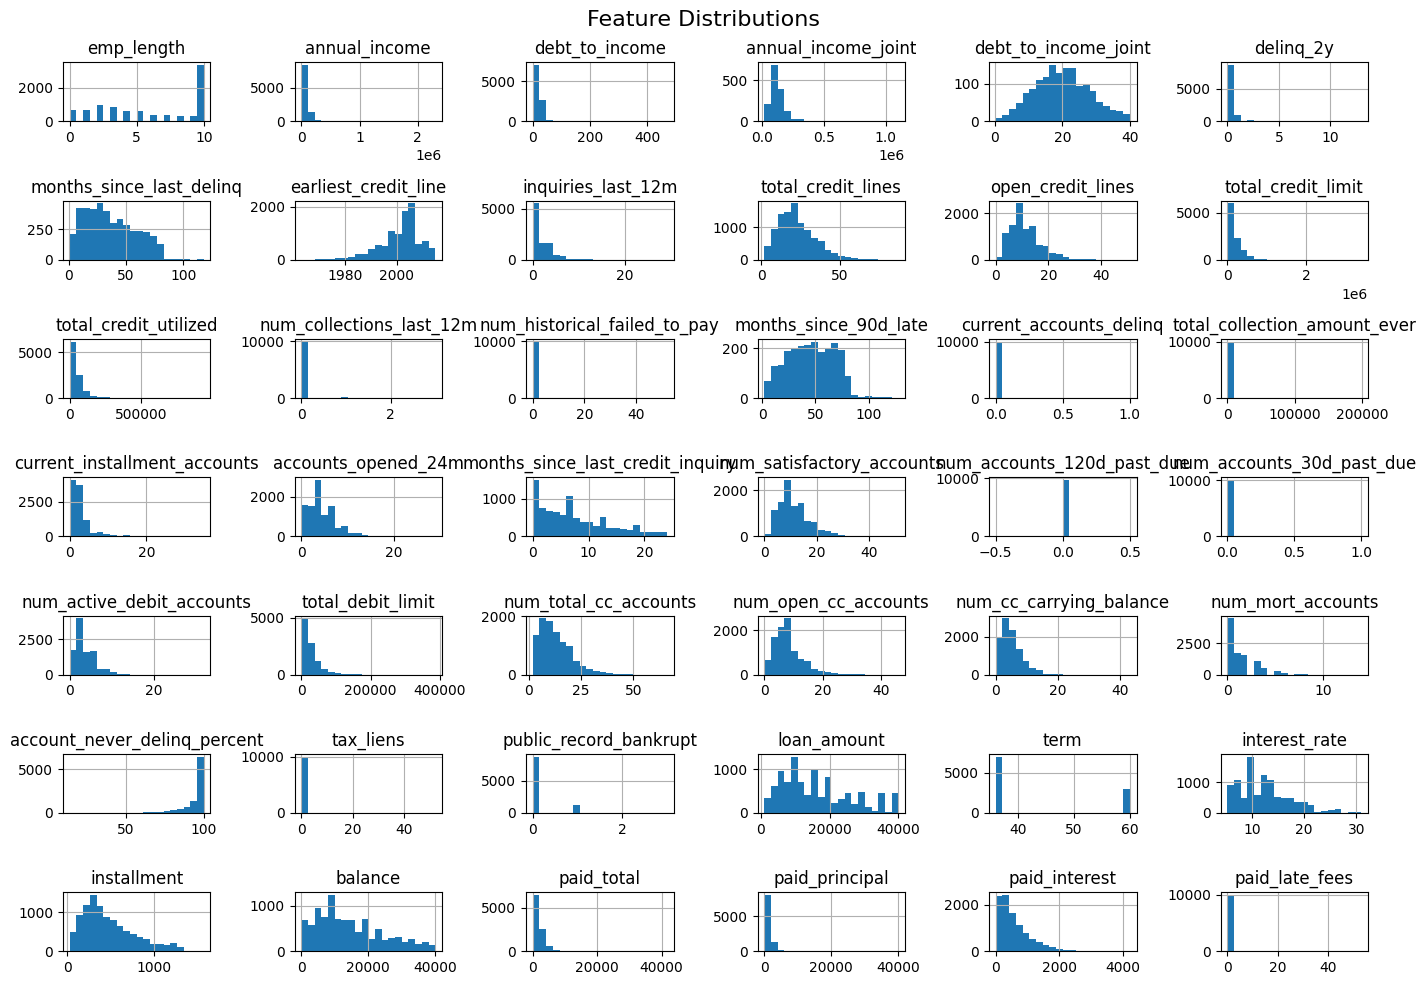

In [48]:
# 📈 Histograms of Features
df.hist(figsize=(14, 10), bins=20)
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()

In [54]:
# 🧼 Replace zero with NaN in medically implausible columns
zero_to_nan = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[zero_to_nan] = df[zero_to_nan].replace(0, pd.NA)

# 🩺 Impute missing values with mean
imputer = SimpleImputer(strategy="mean")
df[zero_to_nan] = imputer.fit_transform(df[zero_to_nan])

# 📊 Outcome Distribution
sns.countplot(x='Outcome', data=df)
plt.title("Outcome Distribution (0 = No Diabetes, 1 = Diabetes)")
plt.show()

# 🔗 Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

KeyError: "None of [Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'], dtype='object')] are in the [columns]"

In [49]:
# 🧹 Drop columns with >80% missing values
df = df.loc[:, df.isnull().mean() < 0.8]

# 🚫 Drop text-heavy or irrelevant columns
drop_cols = ['emp_title', 'earliest_credit_line', 'issue_month', 'sub_grade', 'initial_listing_status']
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

In [50]:
# 🔄 Encode categorical variables
cat_cols = df.select_dtypes(include='object').columns
df[cat_cols] = df[cat_cols].fillna('Missing')
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# 🧼 Impute numeric missing values
df = df.fillna(df.mean(numeric_only=True))


In [51]:
# 🎯 Define features and target
target = 'loan_status'
X = df.drop(columns=[target])
y = LabelEncoder().fit_transform(df[target])

# 📊 Scale features
X_scaled = StandardScaler().fit_transform(X)

In [52]:
# 🎲 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🤖 Model training
models = {
    "🌲 LightGBM": LGBMClassifier(),
    "🧭 SVM": SVC(probability=True)
}

In [53]:
# 📈 Final Evaluation After Tuning
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

for name, model in models.items():
    y_pred = model.predict(X_test)

    print(f"\n📋 {name} Final Report:")
    print(classification_report(y_test, y_pred))
    print("✅ Precision:", precision_score(y_test, y_pred, average='macro'))
    print("🔁 Recall:", recall_score(y_test, y_pred, average='macro'))
    print("🎯 F1 Score:", f1_score(y_test, y_pred, average='macro'))
    print("🧾 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


NotFittedError: Estimator not fitted, call fit before exploiting the model.

🔼 Head:
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0           35.0      NaN  33.6   
1            1     85.0           66.0           29.0      NaN  26.6   
2            8    183.0           64.0            NaN      NaN  23.3   
3            1     89.0           66.0           23.0     94.0  28.1   
4            0    137.0           40.0           35.0    168.0  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

🔽 Tail:
      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
763           10    101.0           76.0           48.0    180.0  32.9   
764            2    122.0           70.0           27.0      NaN  36.8   
765            5    121.0           72.0           23.0    112

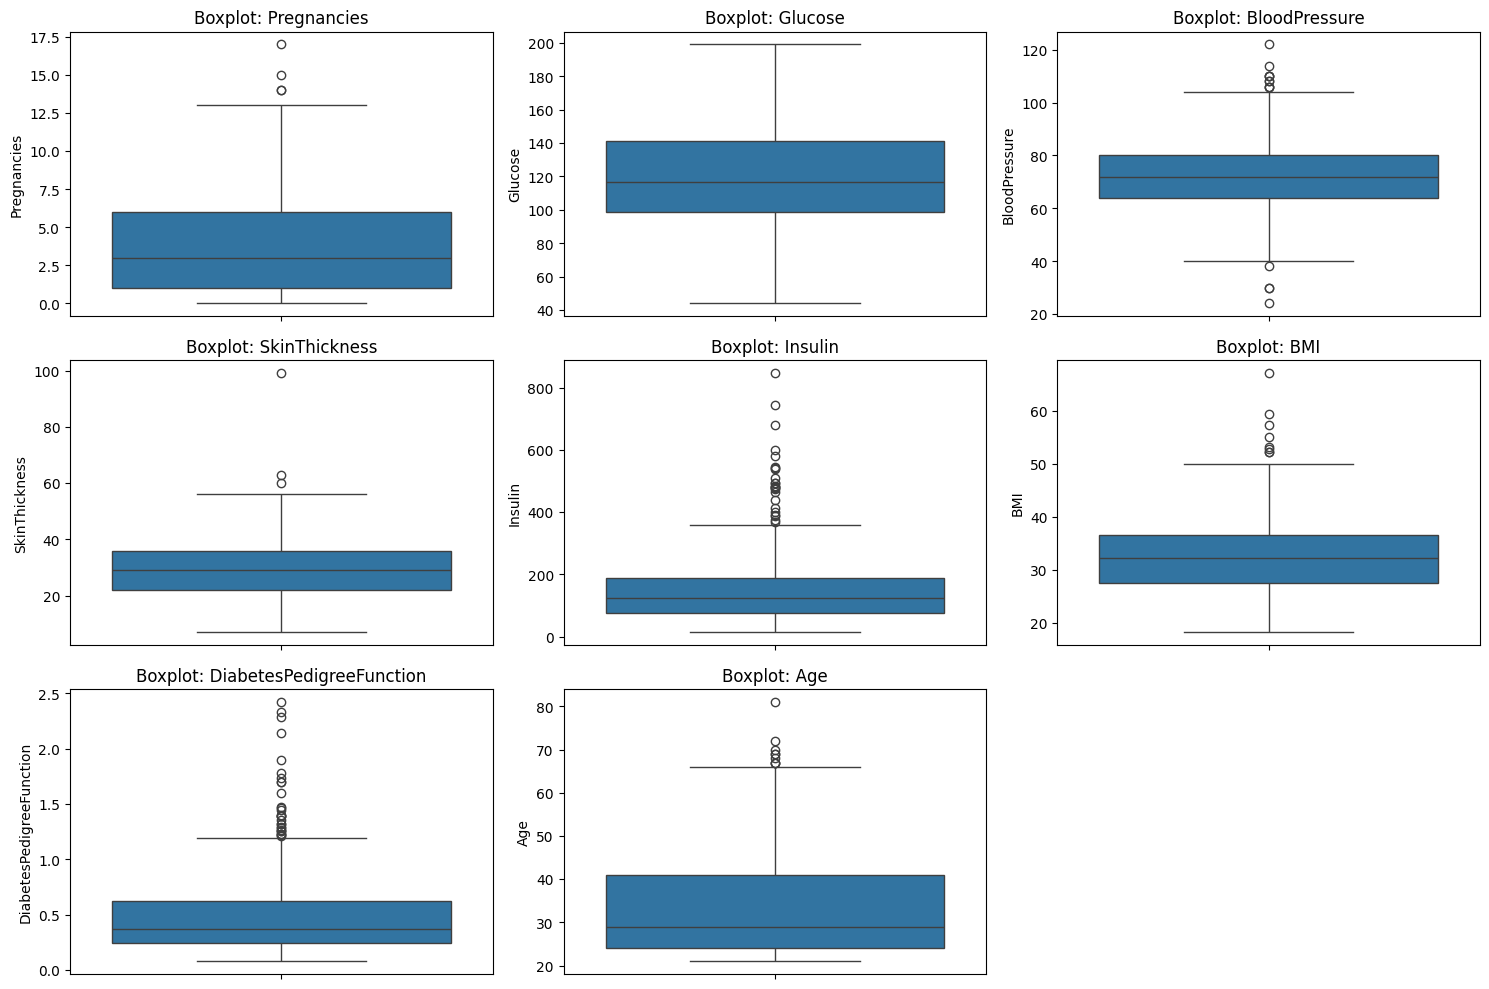

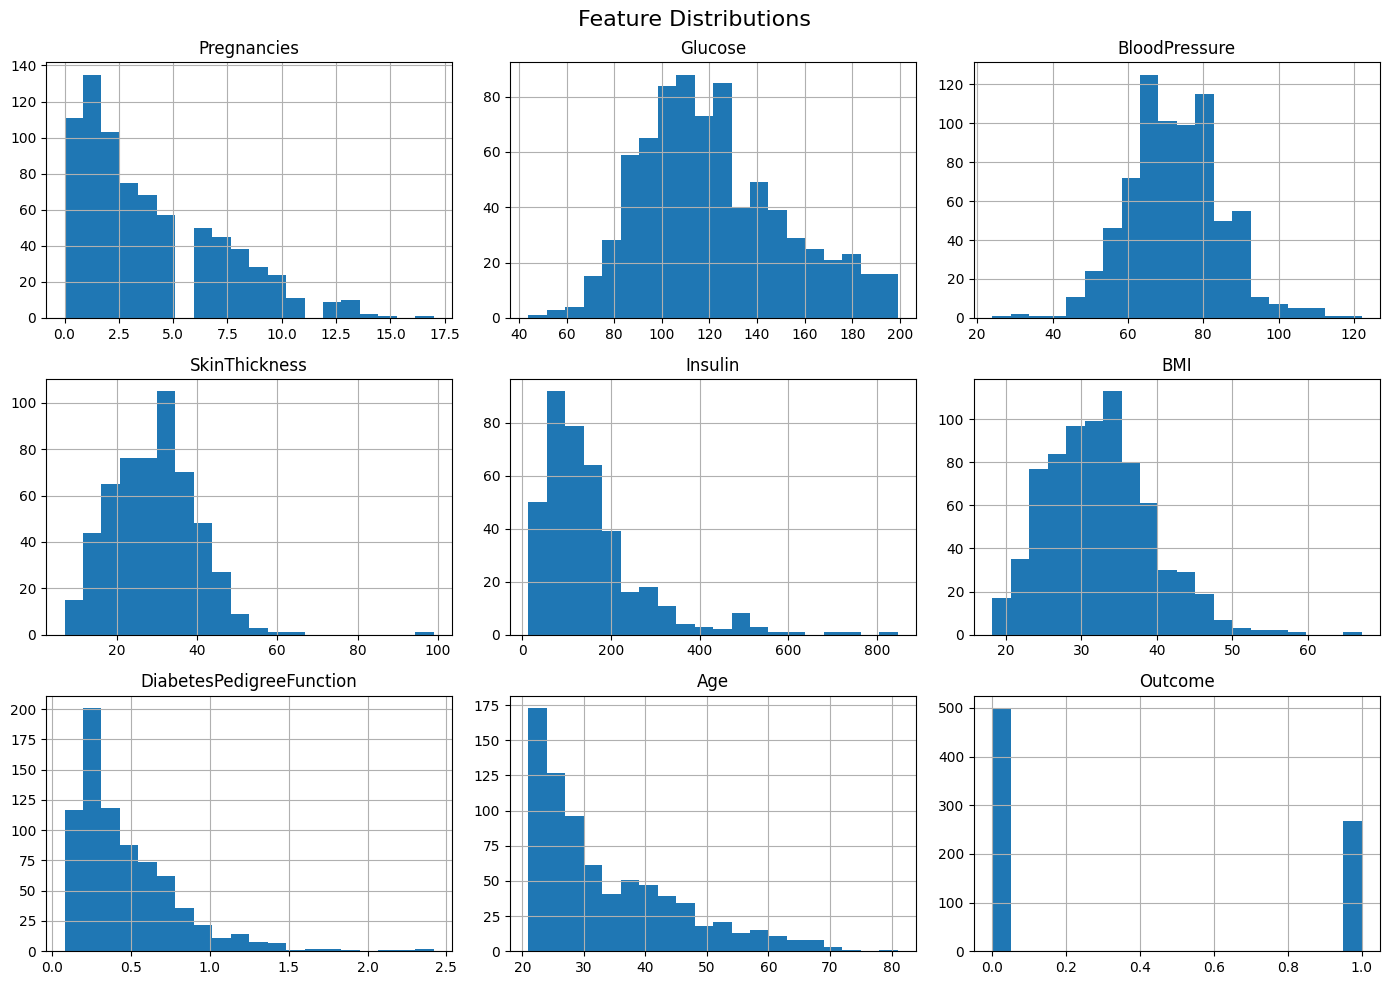

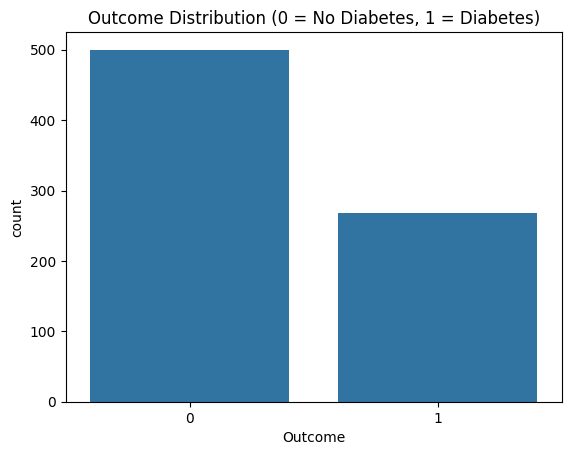

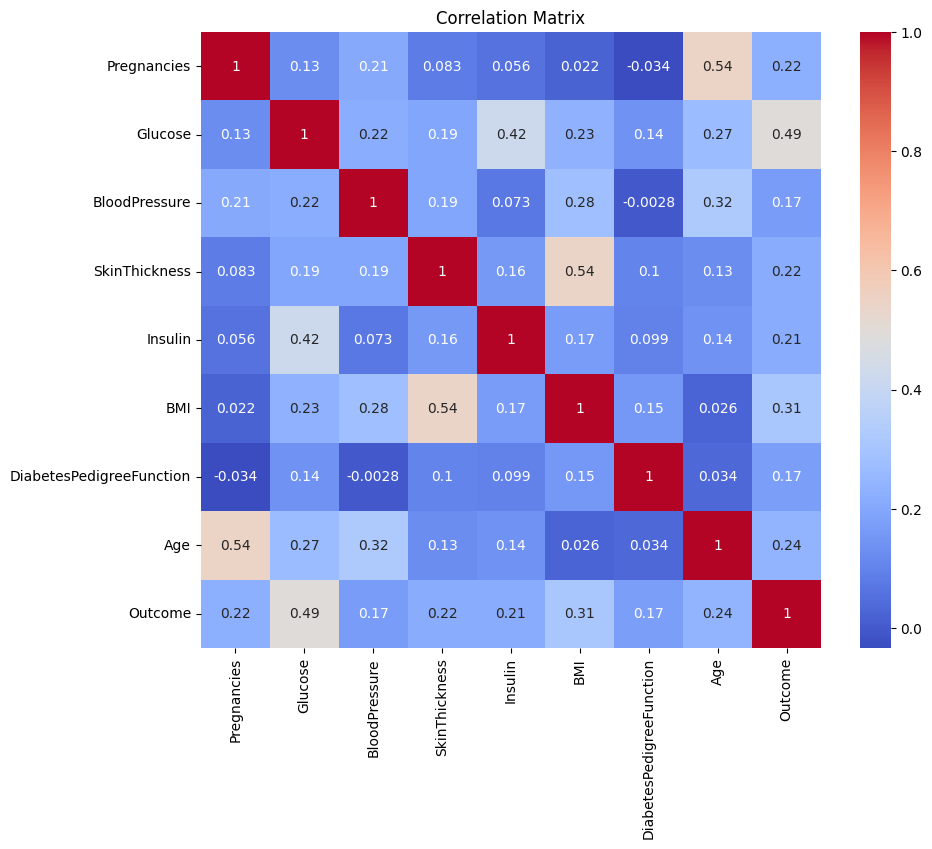


📋 Gradient Boosting Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79        99
           1       0.62      0.69      0.66        55

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154

🎯 F1 Score: 0.6551724137931034
📈 ROC AUC Score: 0.8159779614325069
🧾 Confusion Matrix:
 [[76 23]
 [17 38]]

📋 SVM Report:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        99
           1       0.68      0.58      0.63        55

    accuracy                           0.75       154
   macro avg       0.73      0.72      0.72       154
weighted avg       0.75      0.75      0.75       154

🎯 F1 Score: 0.6274509803921569
📈 ROC AUC Score: 0.8102846648301193
🧾 Confusion Matrix:
 [[84 15]
 [23 32]]

📋 Neural Network Report:
              precision    recall  f1-score   support

       

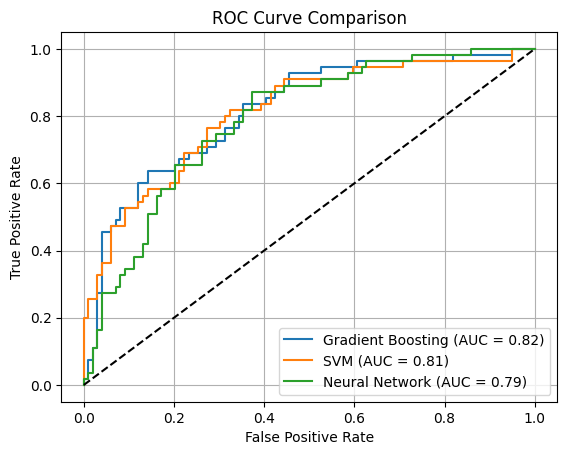

In [ ]:


# ✂️ Features & Target
X = df.drop(columns=['Outcome'])
y = df['Outcome']

# ⚖️ Scaling Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🎲 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🤖 Define Models
models = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(probability=True),
    "Neural Network": MLPClassifier(max_iter=500)
}

# 📊 Training & Evaluation
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"\n📋 {name} Report:")
    print(classification_report(y_test, y_pred))
    print("🎯 F1 Score:", f1_score(y_test, y_pred))
    print("📈 ROC AUC Score:", roc_auc_score(y_test, y_prob))
    print("🧾 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # 📈 Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_prob):.2f})')

# 🏁 Final ROC Curve Plot
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()
